<a href="https://colab.research.google.com/github/ncy906302/Django-Nginx-uwsgi-setting/blob/master/image_segmentation_tf_dataset_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [128]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [129]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
x_train, x_valid, y_train, y_valid = split_data(np.array(input_img_paths), np.array(target_img_paths))
x_train[0]

'images/Maine_Coon_110.jpg'

In [130]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [160, 160])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    # img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = tf.io.read_file(label)
    label = tf.io.decode_png(label)
    # label = tf.image.convert_image_dtype(label, tf.float32)
    label = tf.image.resize(label, [160, 160]) - 1
    label = tf.cast(label, tf.int64)
    return img, label

# def encode_single_sample(img_path, label):
#     # 1. Read image
#     img = tf.io.read_file(img_path)
#     img = tf.io.decode_png(img)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     # 4. Resize to the desired size
#     img = tf.image.resize(img, [160, 160])
#     # 5. Transpose the image because we want the time
#     # dimension to correspond to the width of the image.
#     # 6. Map the characters in label to numbers
#     label = img = tf.io.read_file(label)
#     label = tf.io.decode_png(label)
#     label = tf.image.convert_image_dtype(label, tf.float32)
#     label = tf.image.resize(label, [160, 160])
#     return {"image": img, "label": label}

In [131]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(32)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(32)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [132]:
# for batch in train_dataset.take(1):
#     # images = batch["image"]
#     labels = batch["label"]
#     plt.imshow(labels[0][:,:,0])
#     plt.show()
#     break

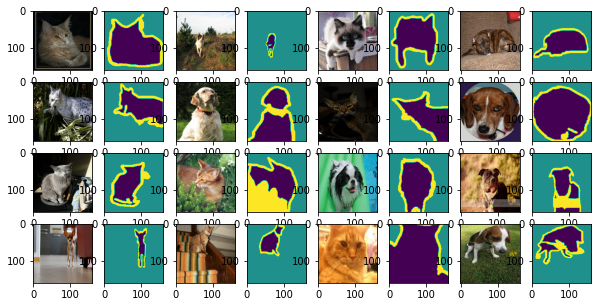

In [133]:
_, ax = plt.subplots(4, 8, figsize=(10, 5))
for batch in train_dataset.take(1):
    images, labels = batch
    for i in range(16):
        img = (images[i]).numpy().astype("uint8")
        label = (labels[i]).numpy().astype("uint8")
        # label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, (i % 4)*2].imshow(img[:, :, ])
        ax[i // 4, (i % 4)*2+1].imshow(label[:, :, 0])
        # ax[i // 4, i % 4].set_title(label)
        # ax[i // 4, i % 4].axis("off")
plt.show()

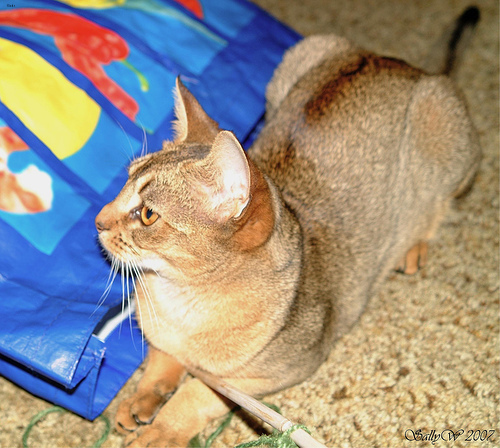

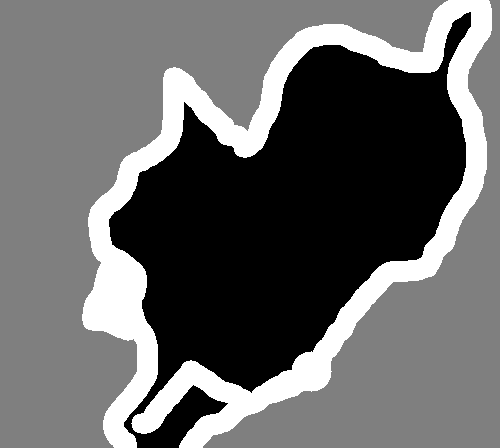

In [134]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps


display(Image(filename=input_img_paths[9]))


img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [135]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


# class OxfordPets(keras.utils.Sequence):
#     """Helper to iterate over the data (as Numpy arrays)."""

#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         self.batch_size = batch_size
#         self.img_size = img_size
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     def __len__(self):
#         return len(self.target_img_paths) // self.batch_size

#     def __getitem__(self, idx):
#         """Returns tuple (input, target) correspond to batch #idx."""
#         i = idx * self.batch_size
#         batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
#         batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
#         x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
#         for j, path in enumerate(batch_input_img_paths):
#             img = load_img(path, target_size=self.img_size)
#             x[j] = img
#         y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
#         for j, path in enumerate(batch_target_img_paths):
#             img = load_img(path, target_size=self.img_size, color_mode="grayscale")
#             y[j] = np.expand_dims(img, 2)
#             # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
#         return x, y



In [136]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,),name='image')
    # labels = keras.Input(batch_size=1,shape=img_size + (3,),name='label')
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    # out = x
    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D()(x)

        # Project residual
        residual = layers.UpSampling2D()(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        # break

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.models.Model(
        inputs=inputs, outputs=outputs, name="ocr_model_v1"
        # inputs=inputs, outputs=out, name="ocr_model_v1"
    )
    # model = keras.Model(images, label)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [137]:
for x, y in train_dataset: break
print(x.shape, x.dtype)
print(y.shape, y.dtype)

(32, 160, 160, 3) <dtype: 'float32'>
(32, 160, 160, 1) <dtype: 'int64'>


In [138]:
keras.losses.sparse_categorical_crossentropy(y, model(x))

<tf.Tensor: shape=(32, 160, 160), dtype=float32, numpy=
array([[[8.83236110e-01, 1.72691846e+00, 1.81118977e+00, ...,
         1.82891417e+00, 1.84060264e+00, 1.87764978e+00],
        [2.59107375e+00, 2.16983032e+00, 2.75689602e+00, ...,
         2.32200456e+00, 2.55678558e+00, 2.86285734e+00],
        [3.02764034e+00, 2.63589311e+00, 2.95850325e+00, ...,
         2.40012074e+00, 2.65831804e+00, 3.02333021e+00],
        ...,
        [1.10258134e-02, 4.46172729e-02, 1.34358779e-01, ...,
         1.23440657e+01, 1.20765295e+01, 1.03650188e+01],
        [9.21957288e-03, 9.83157754e-03, 2.41145194e-02, ...,
         1.24618225e+01, 1.24148970e+01, 1.12943649e+01],
        [9.76337045e-02, 6.70385063e-02, 5.93456551e-02, ...,
         1.14288454e+01, 1.33443813e+01, 9.49943447e+00]],

       [[7.17936554e+01, 1.65099808e+02, 1.80931152e+02, ...,
         1.18522980e+02, 1.24771362e+02, 9.28019562e+01],
        [1.12692863e+02, 1.44643417e+02, 1.55969147e+02, ...,
         1.66276337e+02, 1.

In [139]:
# import random

# # Split our img paths into a training and a validation set
# val_samples = 1000
# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)
# train_input_img_paths = input_img_paths[:-val_samples]
# train_target_img_paths = target_img_paths[:-val_samples]
# val_input_img_paths = input_img_paths[-val_samples:]
# val_target_img_paths = target_img_paths[-val_samples:]

# # Instantiate data Sequences for each split
# train_gen = OxfordPets(
#     batch_size, img_size, train_input_img_paths, train_target_img_paths
# )
# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [140]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
# model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
# model.fit(x=(train_dataset), epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)
model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/15
208/208 [==============================] - 55s 238ms/step - loss: 1.5946 - val_loss: 4.8604
Epoch 2/15
208/208 [==============================] - 47s 227ms/step - loss: 0.5256 - val_loss: 2.9875
Epoch 3/15
208/208 [==============================] - 48s 231ms/step - loss: 0.4379 - val_loss: 0.4405
Epoch 4/15
208/208 [==============================] - 49s 233ms/step - loss: 0.3878 - val_loss: 0.4141
Epoch 5/15
208/208 [==============================] - 49s 233ms/step - loss: 0.3470 - val_loss: 0.4214
Epoch 6/15
208/208 [==============================] - 48s 233ms/step - loss: 0.3159 - val_loss: 0.4135
Epoch 7/15
208/208 [==============================] - 48s 233ms/step - loss: 0.2931 - val_loss: 0.4824
Epoch 8/15
208/208 [==============================] - 49s 233ms/step - loss: 0.2750 - val_loss: 0.4498
Epoch 9/15
208/208 [==============================] - 48s 233ms/step - loss: 0.2624 - val_loss: 0.4065
Epoch 10/15
208/208 [==============================] - 49s 233ms/step - l

In [142]:
# # Generate predictions for all images in the validation set

# val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


# val_preds = model.predict(val_gen)


# def display_mask(i):
#     """Quick utility to display a model's prediction."""
#     mask = np.argmax(val_preds[i], axis=-1)
#     print(mask.shape)
#     mask = np.expand_dims(mask, axis=-1)
#     print(mask.shape)
#     img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#     display(img)


# # Display results for validation image #10
# i = 10

# # Display input image
# display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
# img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

# # Display mask predicted by our model
# display_mask(i)  # Note that the model only sees inputs at 150x150.

In [143]:
!wget https://img04.shop-pro.jp/PA01014/125/slideshow/slideshow_img_11284d.JPG?cmsp_timestamp=20200602215950 -O dog.jpg


--2021-03-24 05:23:20--  https://img04.shop-pro.jp/PA01014/125/slideshow/slideshow_img_11284d.JPG?cmsp_timestamp=20200602215950
Resolving img04.shop-pro.jp (img04.shop-pro.jp)... 99.84.214.110, 99.84.214.103, 99.84.214.46, ...
Connecting to img04.shop-pro.jp (img04.shop-pro.jp)|99.84.214.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2305478 (2.2M) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]   2.20M  --.-KB/s    in 0.01s   

2021-03-24 05:23:21 (181 MB/s) - ‘dog.jpg’ saved [2305478/2305478]



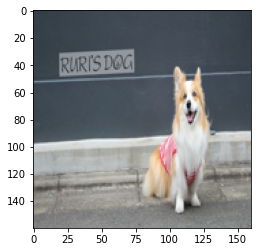

In [144]:
import matplotlib.pyplot as plt

from PIL import Image

img = np.array(Image.open('dog.jpg').resize((160, 160)))
plt.imshow(img)
plt.show()
img = np.array(img).astype(np.float32)

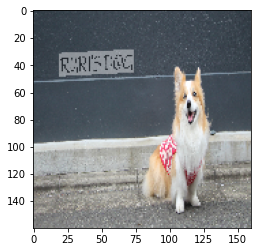

(160, 160)
(160, 160)


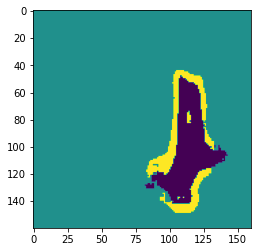

In [145]:
a = load_img('dog.jpg',target_size=(160,160,3))
# new_img = np.array(a).astype(np.float32)
# new_img.resize([160,160,3])
# new_img = np.array([new_img])
# new_img.shape
plt.imshow(a)
plt.show()
img = np.array(a).astype(np.float32)


# pred=model.predict(np.array([val_gen[0][0][0]]))
pred=model.predict(np.array([img]))
mask = np.argmax(pred, axis=-1)
mask = np.squeeze(mask,axis=0)
print(mask.shape)
# mask = np.expand_dims(mask, axis=-1)
print(mask.shape)
plt.imshow(mask)
plt.show()
# img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
# display(img)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)